<a href="https://colab.research.google.com/github/VinniArst/Tugas-Machine-learning/blob/main/Final%20Exam__Twitter_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT** **LIBRARY**

In [1]:
import pandas as pd
import seaborn as sns
import re, nltk
nltk.download('punkt')
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import f1_score
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.layers import Dense, Dropout

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive #menghubungkan file ke direktori drive 
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORT DATASET & PARSE INTO COLUMNS**

In [5]:
data = '/content/drive/MyDrive/dataset/Tweets.csv' # Mengirimkan data pada direktori drive dan disimpan pada variabel data 
df = pd.read_csv(data) # Membaca File csv yang variabel pada data 
df.head() #menampilkan data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [7]:
df.columns #Menampilkan Tulisan Pada Index Data

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [9]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

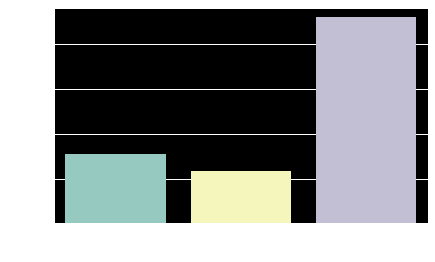

In [10]:
ax = sns.countplot(x='airline_sentiment', data=df)

**Plot Corellation Data**

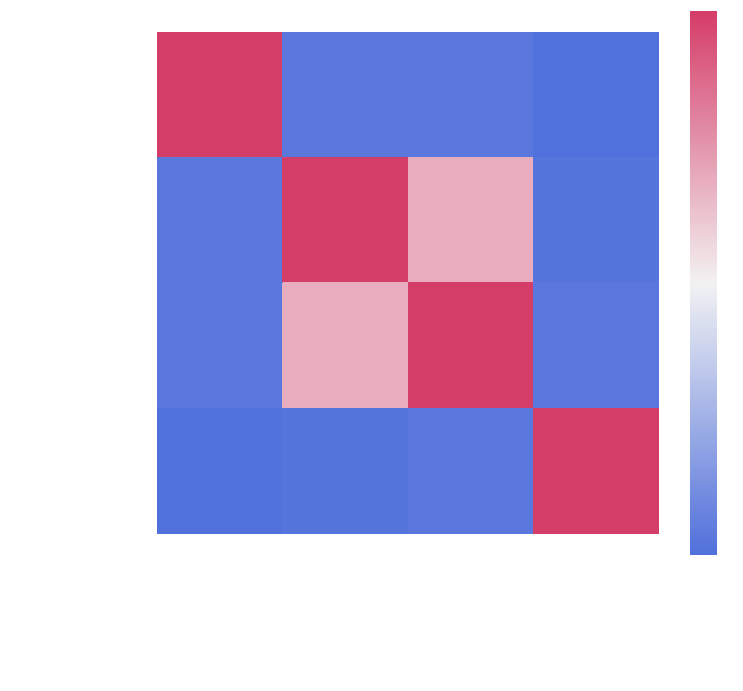

In [11]:
plt.figure(figsize = (10,10)) #menggunakan size map 10x10
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

**EXPLORATORY DATA ANALYSIS**

In [12]:
data_empty = df[['tweet_id', 'negativereason', 'negativereason_confidence', 'negativereason_gold','airline_sentiment_gold', 'airline', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']]
df = df.drop(columns=data_empty)
df

,airline_sentiment,airline_sentiment_confidence,name,text
0,neutral,1.0000,cairdin,@VirginAmerica What @dhepburn said.
1,positive,0.3486,jnardino,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,jnardino,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...
14635,positive,0.3487,KristenReenders,@AmericanAir thank you we got on a different f...
14636,negative,1.0000,itsropes,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,1.0000,sanyabun,@AmericanAir Please bring American Airlines to...
14638,negative,1.0000,SraJackson,"@AmericanAir you have my money, you change my ..."


**positive sentiment**

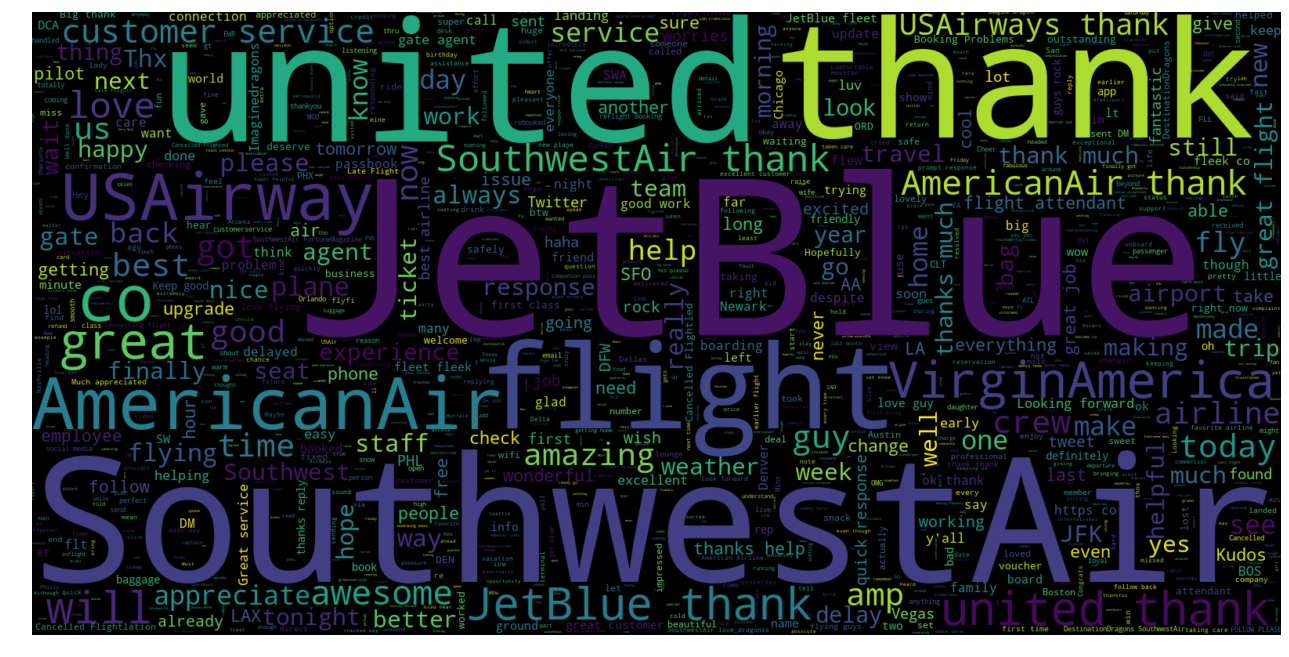

In [13]:
plt.figure(figsize = (20, 20))
plt.grid(False)
wc = WordCloud(
    width = 1600, height = 800,max_words = 3000).generate(
        " ".join(df[df.airline_sentiment == 'positive'].text))
plt.imshow(wc, interpolation = 'bilinear')

**Negative Sentiment**

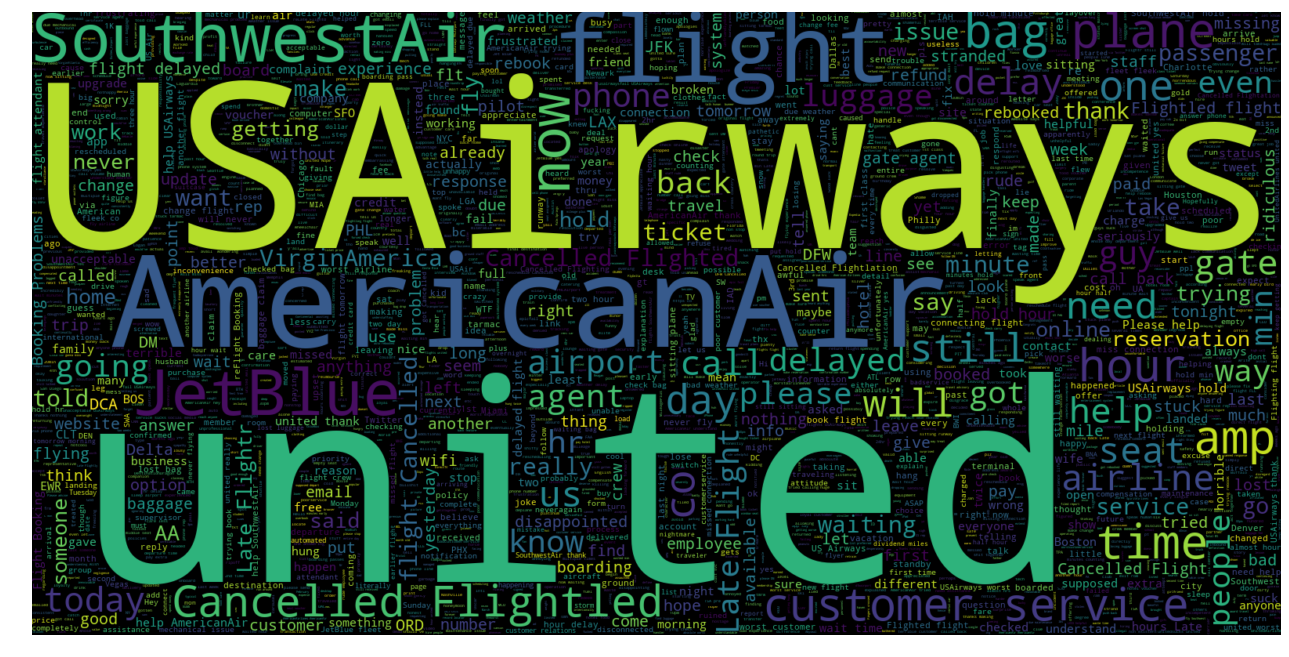

In [14]:
plt.figure(figsize = (20, 20))
plt.grid(False)
wc = WordCloud(
    width = 1600, height = 800,max_words = 3000).generate(
        " ".join(df[df.airline_sentiment == 'negative'].text))
plt.imshow(wc, interpolation = 'bilinear')

**Neutral Sentiment**

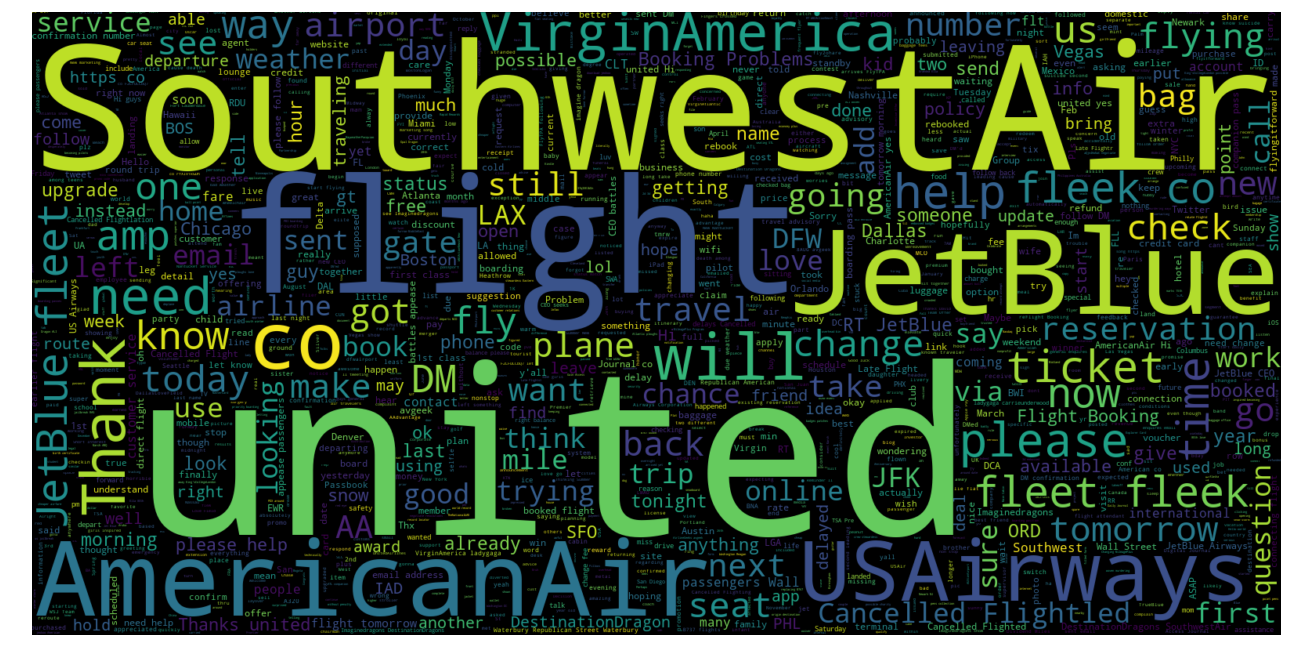

In [15]:
plt.figure(figsize = (20, 20))
plt.grid(False)
wc = WordCloud(
    width = 1600, height = 800,max_words = 3000).generate(
        " ".join(df[df.airline_sentiment == 'neutral'].text))
plt.imshow(wc, interpolation = 'bilinear')

**function for cleaning tweets**

In [16]:
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

**function for removing punctuation**

In [17]:
def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() 
  not in stopwords.words('english')])

**function for checking scores**

In [18]:
def check_scores(clf, X_train, X_test, y_train, y_test):
  model = clf.fit(X_train, y_train)
  predicted_class = model.predict(X_test)
  predicted_class_train = model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
  
  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))
  print()

  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()

  print(classification_report(y_test,predicted_class)) 
  print()

  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()

  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc

In [19]:
def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

**Apply Cleaning Function to Tex**

In [20]:
df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(
    lambda x: 1 if x =='positive' else 0)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,airline_sentiment_confidence,name,text,cleaned_tweet
1,1,0.3486,jnardino,@VirginAmerica plus you've added commercials t...,you ve added commercials to the experience tacky
3,0,1.0000,jnardino,@VirginAmerica it's really aggressive to blast...,s really aggressive to blast obnoxious enterta...
4,0,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,it s a really big bad thing about it
5,0,1.0000,jnardino,@VirginAmerica seriously would pay $30 a fligh...,would pay a flight for seats that didn t have ...
6,1,0.6745,cjmcginnis,"@VirginAmerica yes, nearly every time I fly VX...",nearly every time i fly vx this ear worm won t...


In [21]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,airline_sentiment,airline_sentiment_confidence,name,text,cleaned_tweet
0,1,0.3486,jnardino,@VirginAmerica plus you've added commercials t...,added commercials experience tacky
1,0,1.0000,jnardino,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
2,0,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,really big bad thing
3,0,1.0000,jnardino,@VirginAmerica seriously would pay $30 a fligh...,would pay flight seats playing really bad thin...
4,1,0.6745,cjmcginnis,"@VirginAmerica yes, nearly every time I fly VX...",nearly every time fly vx ear worm go away


In [22]:
df['airline_sentiment'].unique()

array([1, 0])

**Preprocess TF - IDF**

In [23]:
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(
    X_tf_idf, df['airline_sentiment'], random_state=42)

# **Artificial Neural Network**

In [24]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)

model=Sequential()
model.add(Dense(512, input_dim = max_sent_length, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape, y_final.shape

((11541, 124), (11541,))

In [25]:
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_NN, y_train_NN, validation_data = (X_test_NN, y_test_NN), epochs=10, batch_size=64)

Epoch 1/10
127/127 [==============================] - 2s 7ms/step - loss: 0.5351 - accuracy: 0.7715 - val_loss: 0.4627 - val_accuracy: 0.8149
Epoch 2/10
127/127 [==============================] - 1s 4ms/step - loss: 0.4703 - accuracy: 0.8044 - val_loss: 0.4742 - val_accuracy: 0.8097
Epoch 3/10
127/127 [==============================] - 0s 4ms/step - loss: 0.4695 - accuracy: 0.8032 - val_loss: 0.4646 - val_accuracy: 0.8106
Epoch 4/10
127/127 [==============================] - 0s 4ms/step - loss: 0.4703 - accuracy: 0.8035 - val_loss: 0.4630 - val_accuracy: 0.8140
Epoch 5/10
127/127 [==============================] - 0s 4ms/step - loss: 0.4696 - accuracy: 0.8059 - val_loss: 0.4599 - val_accuracy: 0.8132
Epoch 6/10
127/127 [==============================] - 1s 4ms/step - loss: 0.4700 - accuracy: 0.8044 - val_loss: 0.4588 - val_accuracy: 0.8152
Epoch 7/10
127/127 [==============================] - 0s 4ms/step - loss: 0.4683 - accuracy: 0.8066 - val_loss: 0.4630 - val_accuracy: 0.8117
Epoch 

In [26]:
y_test_pred_NN=np.round(model.predict(X_test_NN))
y_train_pred_NN=np.round(model.predict(X_train_NN))
y_test_pred_NN

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [27]:
test_acc_NN = accuracy_score(y_test_NN, y_test_pred_NN)
train_acc_NN = accuracy_score(y_train_NN, y_train_pred_NN)
test_roc_NN = roc_auc_score(y_test_NN, y_test_pred_NN)
train_roc_NN = roc_auc_score(y_train_NN, y_train_pred_NN)

# **GRU**

In [28]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=64
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.4))
model.add(GRU(128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape,y_final.shape

((11541, 124), (11541,))

In [29]:
X_train_GRU, X_test_GRU, y_train_GRU, y_test_GRU = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_GRU, y_train_GRU, validation_data = (X_test_GRU, y_test_GRU), epochs=10, batch_size=64)

Epoch 1/10
127/127 [==============================] - 34s 245ms/step - loss: 0.4214 - accuracy: 0.8252 - val_loss: 0.3014 - val_accuracy: 0.8672
Epoch 2/10
127/127 [==============================] - 29s 231ms/step - loss: 0.2816 - accuracy: 0.8921 - val_loss: 0.3018 - val_accuracy: 0.8773
Epoch 3/10
127/127 [==============================] - 29s 225ms/step - loss: 0.1987 - accuracy: 0.9246 - val_loss: 0.3116 - val_accuracy: 0.8882
Epoch 4/10
127/127 [==============================] - 29s 226ms/step - loss: 0.1560 - accuracy: 0.9400 - val_loss: 0.3646 - val_accuracy: 0.8851
Epoch 5/10
127/127 [==============================] - 29s 226ms/step - loss: 0.1298 - accuracy: 0.9539 - val_loss: 0.3896 - val_accuracy: 0.8773
Epoch 6/10
127/127 [==============================] - 28s 224ms/step - loss: 0.1001 - accuracy: 0.9646 - val_loss: 0.4470 - val_accuracy: 0.8750
Epoch 7/10
127/127 [==============================] - 29s 226ms/step - loss: 0.0808 - accuracy: 0.9725 - val_loss: 0.5003 - val_ac

In [30]:
y_test_pred_GRU=np.round(model.predict(X_test_GRU))
y_train_pred_GRU=np.round(model.predict(X_train_GRU))
y_test_pred_GRU

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [31]:
test_acc_GRU = accuracy_score(y_test_GRU, y_test_pred_GRU)
train_acc_GRU = accuracy_score(y_train_GRU, y_train_pred_GRU)
test_roc_GRU = roc_auc_score(y_test_GRU, y_test_pred_GRU)
train_roc_GRU = roc_auc_score(y_train_GRU, y_train_pred_GRU)

# **LSTM**

In [32]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=64
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape,y_final.shape

((11541, 124), (11541,))

In [33]:
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_LSTM, y_train_LSTM, validation_data = (X_test_LSTM, y_test_LSTM), epochs=10, batch_size=64)

Epoch 1/10
127/127 [==============================] - 39s 286ms/step - loss: 0.4544 - accuracy: 0.8118 - val_loss: 0.3086 - val_accuracy: 0.8750
Epoch 2/10
127/127 [==============================] - 36s 285ms/step - loss: 0.2537 - accuracy: 0.8982 - val_loss: 0.2858 - val_accuracy: 0.8900
Epoch 3/10
127/127 [==============================] - 36s 284ms/step - loss: 0.1890 - accuracy: 0.9234 - val_loss: 0.3050 - val_accuracy: 0.8871
Epoch 4/10
127/127 [==============================] - 36s 280ms/step - loss: 0.1518 - accuracy: 0.9429 - val_loss: 0.3504 - val_accuracy: 0.8819
Epoch 5/10
127/127 [==============================] - 36s 283ms/step - loss: 0.1238 - accuracy: 0.9556 - val_loss: 0.3963 - val_accuracy: 0.8747
Epoch 6/10
127/127 [==============================] - 36s 281ms/step - loss: 0.1020 - accuracy: 0.9634 - val_loss: 0.4140 - val_accuracy: 0.8758
Epoch 7/10
127/127 [==============================] - 36s 283ms/step - loss: 0.0889 - accuracy: 0.9686 - val_loss: 0.4637 - val_ac

In [34]:
y_test_pred_LSTM=np.round(model.predict(X_test_LSTM))
y_train_pred_LSTM=np.round(model.predict(X_train_LSTM))
y_test_pred_LSTM

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [35]:
test_acc_LSTM = accuracy_score(y_test_LSTM, y_test_pred_LSTM)
train_acc_LSTM = accuracy_score(y_train_LSTM, y_train_pred_LSTM)
test_roc_LSTM = roc_auc_score(y_test_LSTM, y_test_pred_LSTM)
train_roc_LSTM = roc_auc_score(y_train_LSTM, y_train_pred_LSTM)

# **RANDOM FOREST**

Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2215  108]
 [ 238  325]]

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2323
           1       0.75      0.58      0.65       563

    accuracy                           0.88      2886
   macro avg       0.83      0.77      0.79      2886
weighted avg       0.87      0.88      0.87      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8801108801108801

Train ROC-AUC score:  0.9982442661479861
Test ROC-AUC score:  0.8956867344777572

Are under Precision-Recall curve: 0.6526104417670683
Area under ROC-AUC: 0.7441899264879837


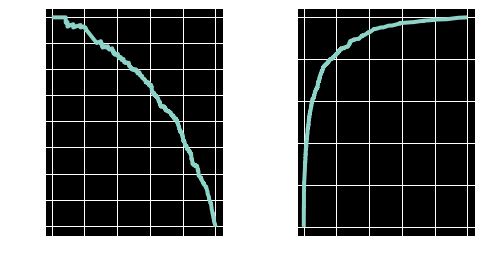

In [36]:
rf = RandomForestClassifier(random_state=0)
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(rf, x_train, x_test, y_train, y_test)

# **SVM**

Train confusion matrix is: 
[[6824   31]
 [ 151 1649]]

Test confusion matrix is: 
[[2291   32]
 [ 296  267]]

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2323
           1       0.89      0.47      0.62       563

    accuracy                           0.89      2886
   macro avg       0.89      0.73      0.78      2886
weighted avg       0.89      0.89      0.87      2886


Train accuracy score:  0.9789716926632005
Test accuracy score:  0.8863478863478863

Train ROC-AUC score:  0.9969059080962801
Test ROC-AUC score:  0.929176839222265

Are under Precision-Recall curve: 0.6194895591647333
Area under ROC-AUC: 0.804984551256201


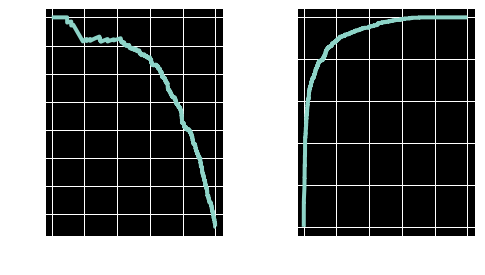

In [37]:
SVM = svm.SVC(probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM, x_train, x_test, y_train, y_test)

# **Multinominal Naive Bayes**

Train confusion matrix is: 
[[6853    2]
 [1296  504]]

Test confusion matrix is: 
[[2318    5]
 [ 474   89]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2323
           1       0.95      0.16      0.27       563

    accuracy                           0.83      2886
   macro avg       0.89      0.58      0.59      2886
weighted avg       0.85      0.83      0.78      2886


Train accuracy score:  0.8500288850375506
Test accuracy score:  0.834026334026334

Train ROC-AUC score:  0.9561105438041981
Test ROC-AUC score:  0.9013005324009118

Are under Precision-Recall curve: 0.2709284627092846
Area under ROC-AUC: 0.7374839454006489


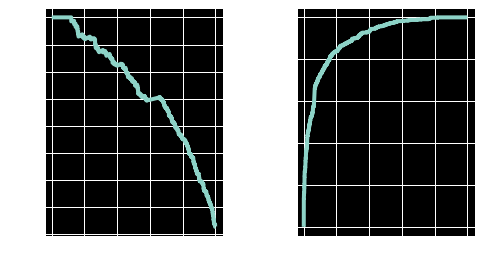

In [38]:
m_naive_bayes = MultinomialNB()
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(m_naive_bayes ,x_train, x_test, y_train, y_test)

# **Evaluation Summary**

In [39]:
data = [('Artificial Neural Network',train_acc_NN, test_acc_NN, train_roc_NN, test_roc_NN),
        ('LSTM',train_acc_LSTM, test_acc_LSTM, train_roc_LSTM, test_roc_LSTM),
        ('Multinomial Naive Bayes',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc),
        ('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
        ('SVM', s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc),
        ('GRU', train_acc_GRU, test_acc_GRU, train_roc_GRU, test_roc_GRU)]
       


summary=pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
summary.set_index('Model Name', inplace = True)
summary

,Train Accuracy,Test Accuracy,Train ROC,Test ROC
Model Name,,,,
Artificial Neural Network,0.807626,0.818077,0.569071,0.578950
LSTM,0.990963,0.860814,0.988995,0.767202
Multinomial Naive Bayes,0.850029,0.834026,0.956111,0.901301
Random Forest,0.996418,0.880111,0.998244,0.895687
SVM,0.978972,0.886348,0.996906,0.929177
GRU,0.991087,0.864857,0.989957,0.775691
